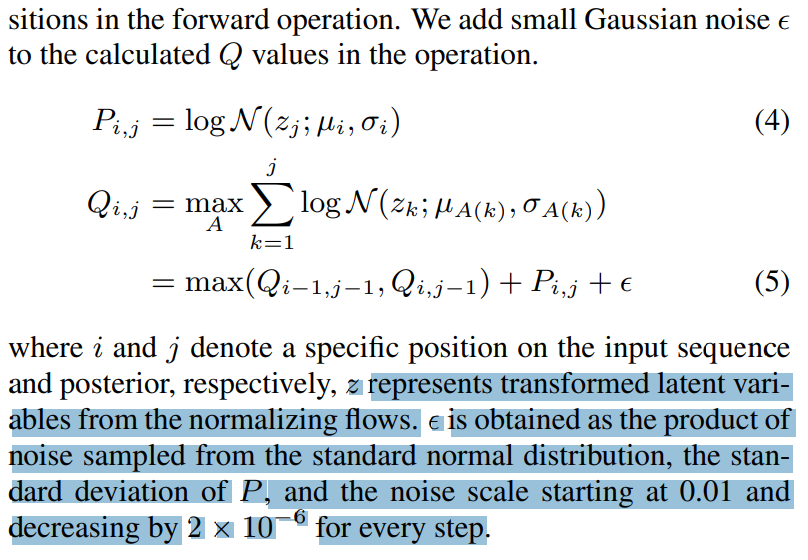

In [1]:
import os
os.chdir(r'../../vits2_pytorch')

In [2]:
import math
import torch
from torch import nn
from torch.nn import functional as F

import monotonic_align
import matplotlib.pyplot as plt

x_mask = torch.ones([1, 1, 5])
y_mask = torch.ones([1, 1, 15])
z_p = torch.randn([1, 192, 15])
m_p = torch.randn([1, 192, 5]) 
logs_p = torch.randn([1, 192, 5])

noise_scale_initial = 0.01
noise_scale_delta = 2e-6

s_p_sq_r = torch.exp(-2 * logs_p) # [b, d, t]
neg_cent1 = torch.sum(-0.5 * math.log(2 * math.pi) - logs_p, [1], keepdim=True) # [b, 1, t_s]
neg_cent2 = torch.matmul(-0.5 * (z_p ** 2).transpose(1, 2), s_p_sq_r) # [b, t_t, d] x [b, d, t_s] = [b, t_t, t_s]
neg_cent3 = torch.matmul(z_p.transpose(1, 2), (m_p * s_p_sq_r)) # [b, t_t, d] x [b, d, t_s] = [b, t_t, t_s]
neg_cent4 = torch.sum(-0.5 * (m_p ** 2) * s_p_sq_r, [1], keepdim=True) # [b, 1, t_s]
neg_cent = neg_cent1 + neg_cent2 + neg_cent3 + neg_cent4

attn_mask = torch.unsqueeze(x_mask, 2) * torch.unsqueeze(y_mask, -1)

c:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


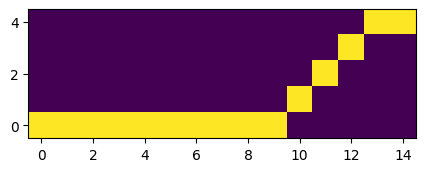

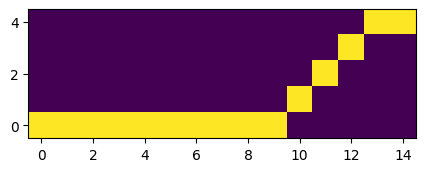

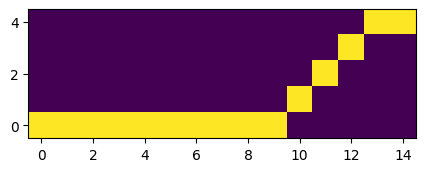

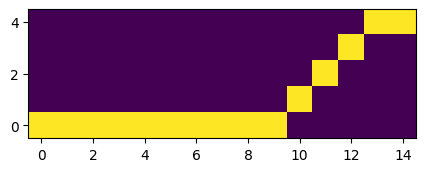

In [5]:
episilon1 = epsilon = 0
neg_cent1 = neg_cent + episilon1
attn1 = attn = monotonic_align.maximum_path(neg_cent1, attn_mask.squeeze(1)).unsqueeze(1).detach()

epsilon2 = torch.randn_like(neg_cent) * (0.01) * torch.std(neg_cent)
neg_cent2 = neg_cent + epsilon
attn2 = monotonic_align.maximum_path(neg_cent2, attn_mask.squeeze(1)).unsqueeze(1).detach()

epsilon3 = torch.randn_like(neg_cent) * (0.01 - (100*noise_scale_delta)) * torch.std(neg_cent)
neg_cent3 = neg_cent + epsilon2
attn3 = monotonic_align.maximum_path(neg_cent3, attn_mask.squeeze(1)).unsqueeze(1).detach()

epsilon4 = torch.randn_like(neg_cent) * (0.01 - (5000*noise_scale_delta)) * torch.std(neg_cent)
neg_cent4 = neg_cent + epsilon2
attn4 = monotonic_align.maximum_path(neg_cent3, attn_mask.squeeze(1)).unsqueeze(1).detach()

plt.figure(figsize=(5, 5))
plt.imshow(attn[0][0].T, origin='lower')
plt.figure(figsize=(5, 5))
plt.imshow(attn2[0][0].T, origin='lower')
plt.figure(figsize=(5, 5))
plt.imshow(attn3[0][0].T, origin='lower')
plt.figure(figsize=(5, 5))
plt.imshow(attn4[0][0].T, origin='lower')

In [6]:
#sanity check
from models import SynthesizerTrn
net_g = SynthesizerTrn(
    n_vocab=256,
    spec_channels=80,
    segment_size=8192,
    inter_channels=192,
    hidden_channels=192,
    filter_channels=768,
    n_heads=2,
    n_layers=6,
    kernel_size=3,
    p_dropout=0.1,
    resblock="1", 
    resblock_kernel_sizes=[3, 7, 11],
    resblock_dilation_sizes=[[1, 3, 5], [1, 3, 5], [1, 3, 5]],
    upsample_rates=[8, 8, 2, 2],
    upsample_initial_channel=512,
    upsample_kernel_sizes=[16, 16, 4, 4],
    n_speakers=0,
    gin_channels=0,
    use_sdp=True,
    use_transformer_flows=True,
    use_spk_conditioned_encoder=True,
    use_noise_scaled_mas=True,
)


In [7]:
for i in range(1,10000,1000):
    if net_g.use_noise_scaled_mas:
      current_mas_noise_scale = net_g.mas_noise_scale_initial - (net_g.noise_scale_delta * i)
      net_g.current_mas_noise_scale = max(current_mas_noise_scale, 0)
    print(i, net_g.current_mas_noise_scale)

1 0.009998
1001 0.007998
2001 0.005998000000000001
3001 0.003998000000000001
4001 0.0019979999999999998
5001 0
6001 0
7001 0
8001 0
9001 0
